In [637]:
import pandas as pd
import numpy as np
import re

In [638]:
df = pd.read_excel('data_daily_reports.xlsx')
df.head()

,No.,Date Report (mm/dd/yyyy),Content
0,1,2025-05-16,■ TRAN VAN DANG - 2025/05/15\n \n■■■■■■■■■■■■■...
1,2,2025-05-16,Hồ Huỳnh Lâm\n#### 20250516\n_________________...
2,3,2025-05-16,#### 2025/05/15 TRAN VAN SU 8:00 - 17:20\n■本日...
3,4,2025-05-16,■ 05/15 PHAM LONG DINH\n\n● 2025/05/15\n \n■■■...
4,5,2025-05-16,■ 05/15 TRAN VIET DUC\n● 2025/05/15\n■■■ Plan ...


In [639]:
df['Date Report'] = pd.to_datetime(df['Date Report (mm/dd/yyyy)'], format='%Y-%m-%d', errors='coerce')

## GET NAME IN FIELD CONTENT

In [640]:
def extract_name(content):
    content = str(content).strip()
    
    # Pattern 1: ■ TRAN VAN DANG - 2025/05/15
    pattern1 = r"^■\s*([A-ZÀ-Ỹà-ỹ\s]+?)\s*[-–]"
    match1 = re.search(pattern1, content)
    if match1:
        name = match1.group(1).strip()
        # Remove any numbers that might be in the name
        name = re.sub(r'\d+', '', name).strip()
        return name
    
    # Pattern 2: Hồ Huỳnh Lâm (trên dòng đầu tiên, không có ■)
    # Tìm tên trên dòng đầu tiên nếu không bắt đầu bằng ■ hoặc ####
    lines = content.split('\n')
    first_line = lines[0].strip()
    if not first_line.startswith('■') and not first_line.startswith('####'):
        # Kiểm tra xem có phải là tên không (chứa chữ cái và có thể có dấu tiếng Việt)
        if re.match(r'^[A-ZÀ-Ỹa-zà-ỹ\s]+$', first_line) and len(first_line.split()) >= 2:
            return first_line.strip()
    
    # Pattern 3: #### 2025/05/15 TRAN VAN SU  8:00 - 17:20
    pattern3 = r"####\s*\d{4}/\d{2}/\d{2}\s+([A-ZÀ-Ỹà-ỹ\s]+?)(?:\s+\d|$)"
    match3 = re.search(pattern3, content)
    if match3:
        name = match3.group(1).strip()
        return name
    
    # Pattern 4: ■ 05/15 PHAM LONG DINH hoặc ■ LÊ NGUYÊN TRANG
    pattern4 = r"^■\s*(?:\d{2}/\d{2}\s+)?([A-ZÀ-Ỹà-ỹ\s]+?)(?:\n|$)"
    match4 = re.search(pattern4, content)
    if match4:
        name = match4.group(1).strip()
        # Remove any remaining date patterns
        name = re.sub(r'\d{2}/\d{2}', '', name).strip()
        return name
    
    return ""

In [641]:
df['Member'] = df['Content'].apply(extract_name)
df['Member'].head()

0     TRAN VAN DANG
1      Hồ Huỳnh Lâm
2       TRAN VAN SU
3    PHAM LONG DINH
4     TRAN VIET DUC
Name: Member, dtype: object

## GET THE NUMBER OF REPORTS IN MONTH WITH ALL MEMBERS

In [642]:
def get_summary_by_month(df, month, year):
    df_month = df[
        (df['Date Report'].dt.month == month) &
        (df['Date Report'].dt.year == year)
    ].copy()

    df_summary = df_month[['Date Report', 'Member', 'Content']].sort_values(['Member', 'Date Report']).reset_index(drop=True)

    df_summary['Date Report'] = df_summary['Date Report'].dt.strftime('%Y-%m-%d')

    return df_summary

## STATISTICAL CHART OF THE NUMBER OF REPORTS

In [643]:
import matplotlib.pyplot as plt


def plot_report_stat(df, month, year):
    stat = get_summary_by_month(df, month, year).groupby('Member')['Date Report'].nunique().reset_index()
    stat = stat.rename(columns={'Date Report': 'Total days report'})

    plt.figure(figsize=(10, 6))
    plt.plot(stat['Member'], stat['Total days report'], marker='o', linestyle='-', color='teal', linewidth=2)
    plt.title(f'Total report days in {month:02d}/{year}', fontsize=14, fontweight='bold')
    plt.xlabel('Member', fontsize=12)
    plt.ylabel('Total days reported', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.tight_layout()

    for i, row in stat.iterrows():
        plt.text(row['Member'], row['Total days report'] + 0.2, str(row['Total days report']), ha='center', va='bottom', fontsize=9, color='black')
    
    plt.show()


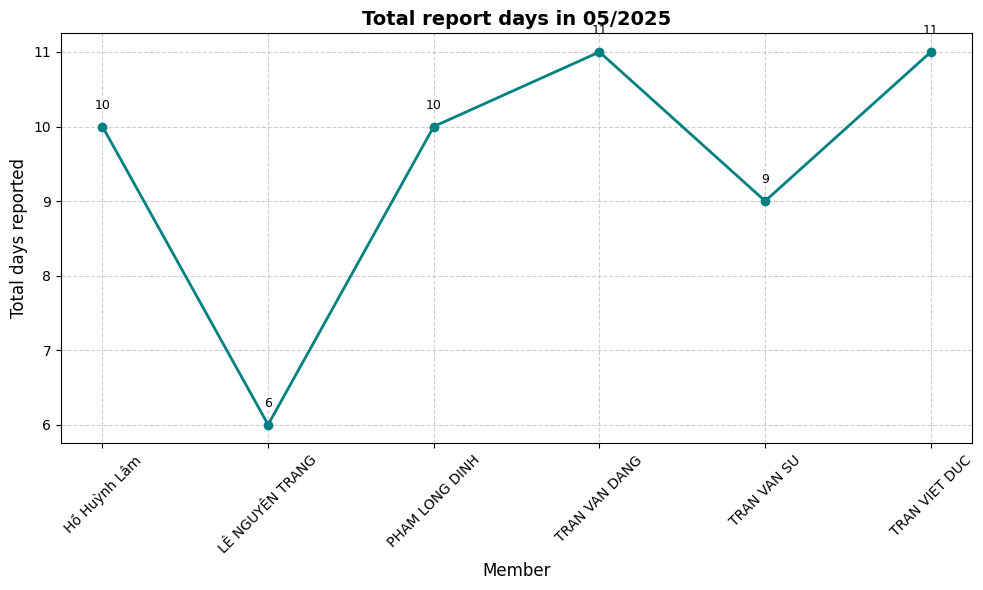

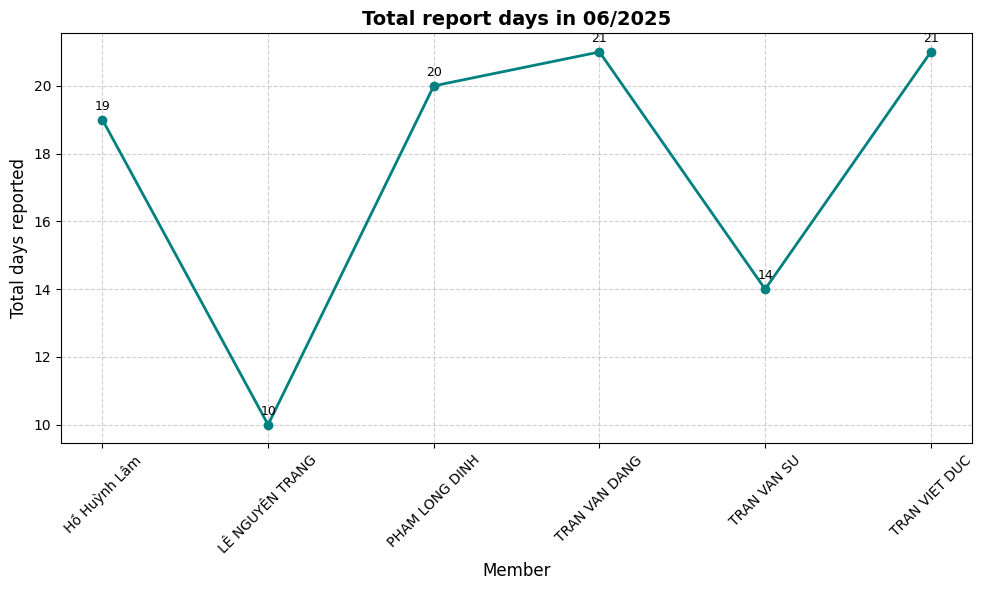

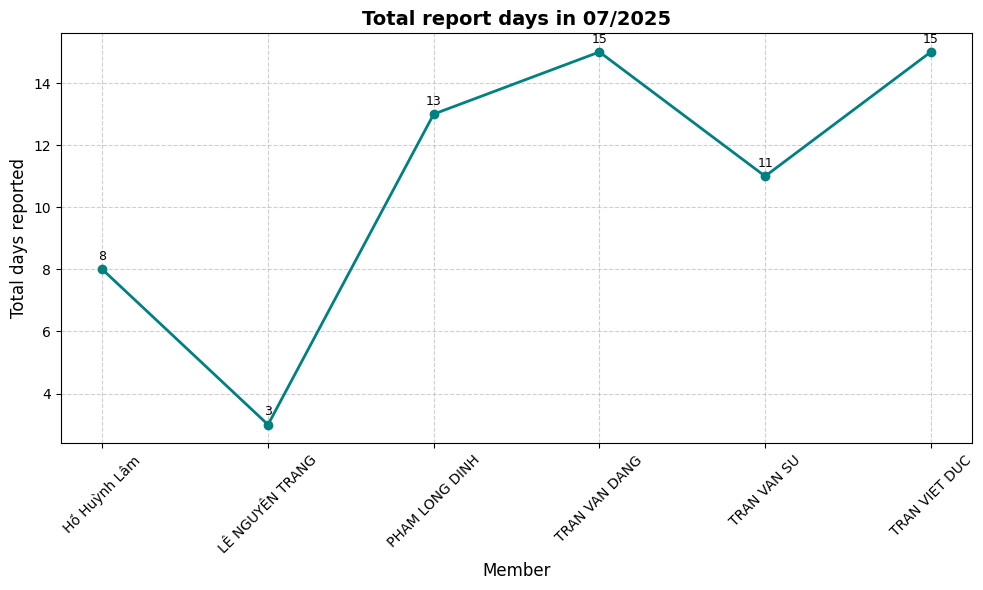

In [644]:
plot_report_stat(df, 5, 2025)
plot_report_stat(df, 6, 2025)
plot_report_stat(df, 7, 2025)

## GET FROM CONTENT TO FIELD -- ACTUAL --

In [645]:
def extract_actual(content):
    if pd.isnull(content):
        return ''
    pat = r'(■{2,}[\s\u3000\u00A0]*Actual[\s\u3000\u00A0]*■{2,}|■■ Today\(Actual - Thực tế\) ■■|Today\(Actual - Thực tế\) ■■)(.*?)(■{2,}[\s\u3000\u00A0]*(?:Next plan|Dự định ngày tiếp theo|Dự định|ISSUE)[\s\u3000\u00A0]*■{0,}|$)'
    
    match = re.search(pat, content, flags=re.DOTALL|re.IGNORECASE|re.UNICODE)
    if match:
        actual = match.group(2)
        actual = re.sub(r'[\r\n]+', '\n', actual)
        actual = actual.strip(' \n\r\t:-\u3000\u00A0')
        return actual.strip()
    
    pat2 = r'■■ Today\(Actual - Thực tế\) ■■(.*?)(■{2,}|Dự định ngày tiếp theo|Dự định|ISSUE|$)'
    match2 = re.search(pat2, content, flags=re.DOTALL|re.IGNORECASE|re.UNICODE)
    if match2:
        actual = match2.group(1)
        actual = re.sub(r'[\r\n]+', '\n', actual)
        actual = actual.strip(' \n\r\t:-\u3000\u00A0')
        return actual.strip()
    
    return None


def extract_actual_yesterday(content):
    pattern = r'(?:Yesterday|Hôm qua)[^\n]*\n(.*?)(?:\n[-=]{3,}|\n\s*(?:Daily plan|Plan for|Next plan|Today|Tomorrow|Dự định|Kế hoạch)[^\n]*\n|$)'
    
    match = re.search(pattern, content, re.DOTALL | re.IGNORECASE)
    if match:
        result = match.group(1).strip()
        result = re.sub(r'[-=]{3,}\s*$', '', result).strip()
        return result
    
    pattern_backup = r'(?:Yesterday|Hôm qua)[^\n]*\n(.*?)(?:\n.*?(?:Daily|Plan|Next|Dự định|Today|Tomorrow)|\n[-=]{5,}|$)'
    match_backup = re.search(pattern_backup, content, re.DOTALL | re.IGNORECASE)
    if match_backup:
        result = match_backup.group(1).strip()
        result = re.sub(r'[-=]{3,}\s*$', '', result).strip()
        return result
    
    return ""


def get_actual(content):
    actual = extract_actual(content)
    if actual:
        return actual
    actual = extract_actual_yesterday(content)
    return actual

In [646]:
df_summary = get_summary_by_month(df, 6, 2025)

In [647]:
df_summary['Actual'] = df_summary['Content'].apply(get_actual)

## GET FROM CONTENT TO FIELD -- NEXT PLAN --

In [648]:
def extract_next_plan(text):
    """
    Trích xuất phần Next Plan từ nội dung báo cáo
    """
    if pd.isna(text):
        return None
    
    # Tìm các pattern có thể có cho Next Plan
    patterns = [
        r'■■■　Next plan.*?■■■(.*?)(?=■■■|$)',  
        r'Next plan.*?■■■(.*?)(?=■■■|$)',        
        r'- Dự định.*?■■■(.*?)(?=■■■|$)',       
        r'■■　Dự định.*?■■(.*?)(?=■■|$)'          
    ]
    
    for pattern in patterns:
        match = re.search(pattern, text, re.DOTALL | re.IGNORECASE)
        if match:
            next_plan_content = match.group(1).strip()
            if next_plan_content:
                return next_plan_content
    
    return None

In [649]:
df_summary['Next Plan'] = df_summary['Content'].apply(extract_next_plan)

## GET FROM CONTENT TO FIELD -- PLAN --

In [650]:
def extract_plan(text):
    """
    Trích xuất phần Plan từ nội dung báo cáo hàng ngày
    """
    if pd.isna(text):
        return None
    
    # Pattern để tìm Plan
    plan_patterns = [
        r'■■■\s*Plan\s*■■■(.*?)(?=■■■|$)',
        r'■■\s*Plan\s*■■(.*?)(?=■■|$)',
        r'■■　Today（Plan[^）]*）■■(.*?)(?=■■|$)',
        r'Today（Plan[^）]*）■■(.*?)(?=■■|$)',
        r'Plan\s*-\s*Dự\s*định[^■]*■■(.*?)(?=■■|$)',
        r'■本日の業務\n(.*?)(?=■■|$)',  # Cập nhật cho trường hợp này
        # Thêm pattern mới cho data 2
        r'■本日の業務\n■\s*([^■]+?)(?=■■\s*Today\(Actual|$)'
    ]
    
    # Trích xuất Plan
    plan_content = None
    for pattern in plan_patterns:
        match = re.search(pattern, text, re.DOTALL | re.IGNORECASE)
        if match:
            plan_content = match.group(1).strip()
            if plan_content:
                break
    
    return plan_content

In [651]:
df_summary['Plan'] = df_summary['Content'].apply(extract_plan)

## ______________________________________________________________________________________

## EXTRACT FILE EXCEL FOR REPORTS IN MONTH

In [652]:
df_summary.to_excel('mat_bo_bao_cao_thang_6_2025.xlsx', index=False)
